# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Problem Statement

The State Legislature of Connecticut is reviewing a bill to legalize sports wagering within the state. The State Legislature must carefully weigh pros and cons when deciding pass or reject the bill. If they pass the bill, the bill moves on to the Sentate for final approval. If the Senate approves, Connecticut would become the 12th state in the United States where sports wagering has been legalized.

A major consideration by the State Legislature is the potential revenue gain in the State General fund. All sources of gaming share revenue with the state and make transfers into the State General fund at the end of the fiscal year. While sports wagering itsself is likely to bring in new revenue for the state, the state must consider reductions in other revenue streams that the new sports wagering revenue stream may cause. 

Using West Virginia has a protype, we will build a ARIMAX time series model that will predict tax revenue for one year, broken down on a weekly basis. After modeling, we will use root mean squared error to measure the model's succes. Our goal is to provide the state with a model that can predict tax revenue as closely as possible, giving the state more confidence to make their decision.

## Table of Contents:
- [Imports](#Imports)
- [Data Cleaning and Exploratory Data Analysis](#Data-Cleaning-and-Exploratory-Data-Analysis)
    - [High-Level-Checks](#High-Level-Checks)
    - [Data Cleaning](#Data-Cleaning)
    - [Feature Relationship Study](#Feature-Relationship-Study)
    - [Time Series Data Analysis](#Time-Series-Data-Analysis)
    - [Autocorrelation and Partial Autocorrelation Functions](#Autocorrelation-and-Partial-Autocorrelation-Functions)
- [Preprocessing](#Preprocessing)
    - [Data Manipulation](#Data-Manipulation)
    - [Train-Test-Split](#Train-Test-Split)
- [Modeling](#Modeling)
    - [Baseline Modeling](#Baseline-Modeling)
    - [Autoregressive Modeling](#Autoregressive-Modeling)
    - [ARIMAX Modeling](#ARIMAX-Modeling)
    - [Model Comparison](#Model-Comparison)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

### Imports

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings 
import warnings
warnings.simplefilter(action="ignore")

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The data set that is being used in our modeling, and is being read in below, includes 52 weeks of data. The data was provided by West Virginia Lottery, in the form of Sports Wagering reports.

In [97]:
# Reading in the data

df = pd.read_csv('./data/wv_combined.csv')

## Data Cleaning and Exploratory Data Analysis

#### High Level Checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 10 columns):
week_ending                52 non-null object
tickets_written            52 non-null int64
 voids                     52 non-null int64
tickets_cashed             52 non-null int64
mobile_taxable_receipts    31 non-null float64
retail_taxable_receipts    52 non-null int64
total_taxable_receipts     52 non-null int64
privilege_tax              52 non-null int64
admin_share                52 non-null int64
state_share                52 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 4.2+ KB


In [4]:
df.columns

Index(['week_ending', 'tickets_written', ' voids  ', 'tickets_cashed',
       'mobile_taxable_receipts', 'retail_taxable_receipts',
       'total_taxable_receipts', 'privilege_tax', 'admin_share',
       'state_share'],
      dtype='object')

In [5]:
df.shape

(52, 10)

In [6]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [7]:
df.dtypes

week_ending                 object
tickets_written              int64
 voids                       int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

In [8]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [9]:
# Finding null values

df.isnull().sum().sort_values(ascending = False)

mobile_taxable_receipts    21
state_share                 0
admin_share                 0
privilege_tax               0
total_taxable_receipts      0
retail_taxable_receipts     0
tickets_cashed              0
 voids                      0
tickets_written             0
week_ending                 0
dtype: int64

In [10]:
# Taking a closer look at null values in relation to the rest of the data

df[df.isna().any(axis=1)]

,week_ending,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
10,3/16/19,2858410,70218,2565896,nan,222296,222296,22230,3334,18895
11,3/23/19,4418971,91090,3554777,nan,773104,773104,77310,11597,65714
12,3/30/19,3443807,67494,3025699,nan,350615,350615,35061,5259,29802
13,4/6/19,2385379,68355,2123295,nan,193729,193729,19373,2906,16467
16,4/27/19,2607302,49943,2587349,nan,-29989,-29989,-2999,-450,-2549
17,5/4/19,2296202,38167,1856748,nan,401287,401287,40129,6019,34109
18,5/11/19,2210385,30720,2190474,nan,-10808,-10808,-1081,-162,-919
19,5/18/19,2176969,44266,1975717,nan,156986,156986,15699,2355,13344
20,5/25/19,1984382,31461,1885233,nan,67688,67688,6769,1015,5754
21,6/1/19,2036091,22197,1691982,nan,321912,321912,32191,4829,27363


#### Data Cleaning

In [11]:
# Filling null values with zeros

df.fillna(0, inplace=True)

In [12]:
# Confirming we no longer have null values

df.isnull().sum().sort_values(ascending = False)

state_share                0
admin_share                0
privilege_tax              0
total_taxable_receipts     0
retail_taxable_receipts    0
mobile_taxable_receipts    0
tickets_cashed             0
 voids                     0
tickets_written            0
week_ending                0
dtype: int64

In [13]:
# Stripping blank spaces out column titles

df.columns = [col.strip() for col in df.columns]

In [14]:
# Converting "week_ending" from a object dtype to a datetime64 dtype

df['week_ending'] = pd.to_datetime(df['week_ending'])

#### Feature Relationship Study

In [15]:
# Framework for a bar chart

#df.groupby("Overall Qual")[["SalePrice"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
#plt.ylabel("Overall Quality", fontsize=18)
#plt.xlabel("Sale Price", fontsize=18)
#plt.title("Sale Price Distribution", fontsize=20);

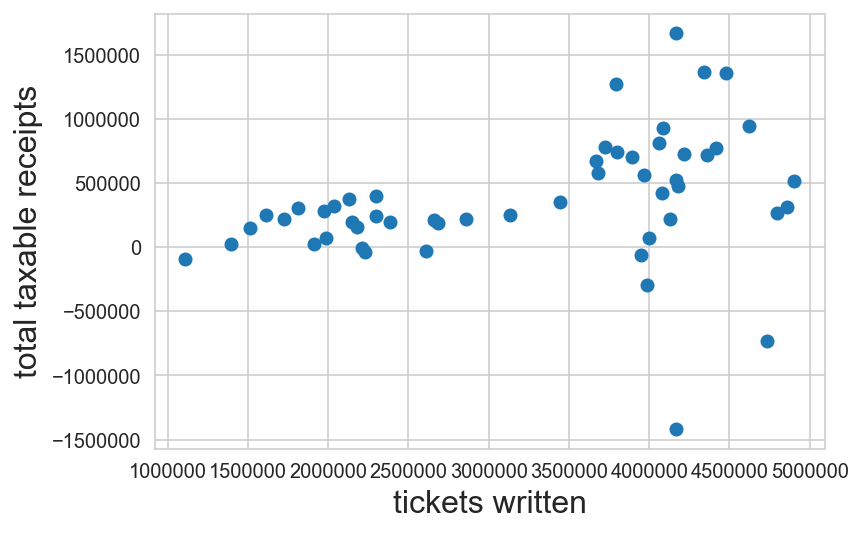

In [16]:
plt.scatter(df["tickets_written"], df["total_taxable_receipts"])
plt.xlabel("tickets written", fontsize = 16)
plt.ylabel("total taxable receipts", fontsize = 16);

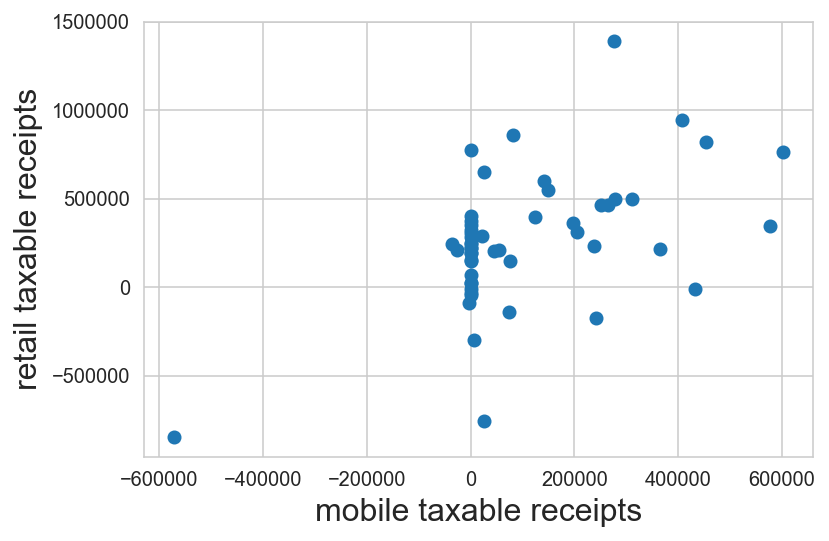

In [17]:
plt.scatter(df['mobile_taxable_receipts'], df['retail_taxable_receipts'])
plt.xlabel("mobile taxable receipts", fontsize = 16)
plt.ylabel("retail taxable receipts", fontsize = 16);

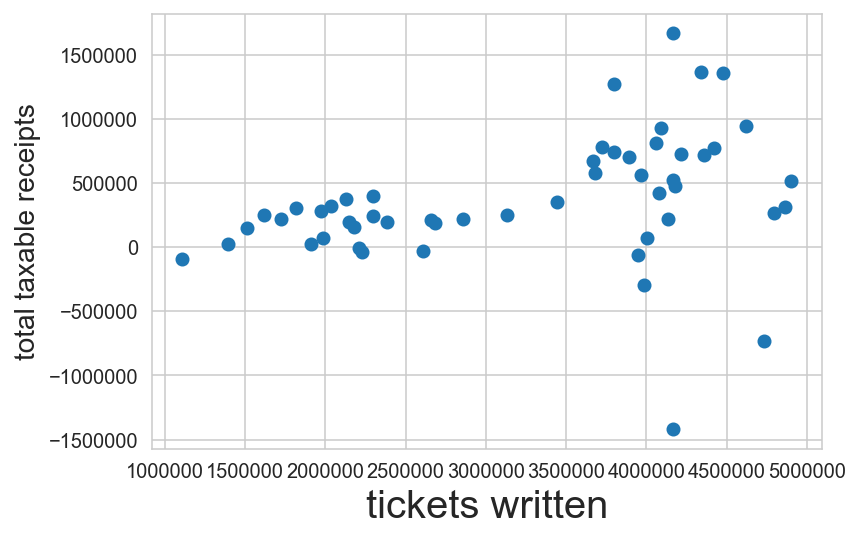

In [18]:
plt.scatter(df['tickets_written'], df['total_taxable_receipts'])
plt.xlabel('tickets written', fontsize = 20)
plt.ylabel('total taxable receipts', fontsize = 14);

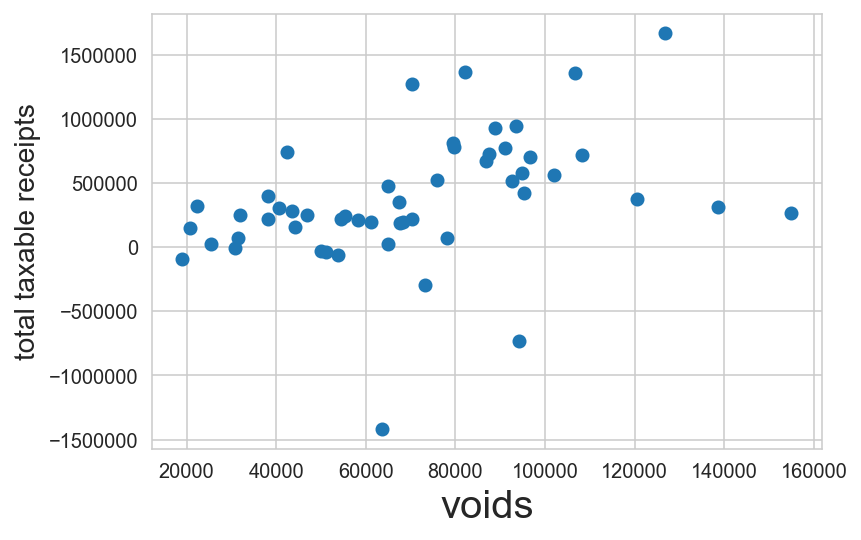

In [19]:
plt.scatter(df['voids'], df['total_taxable_receipts'])
plt.xlabel('voids', fontsize = 20)
plt.ylabel('total taxable receipts', fontsize = 14);

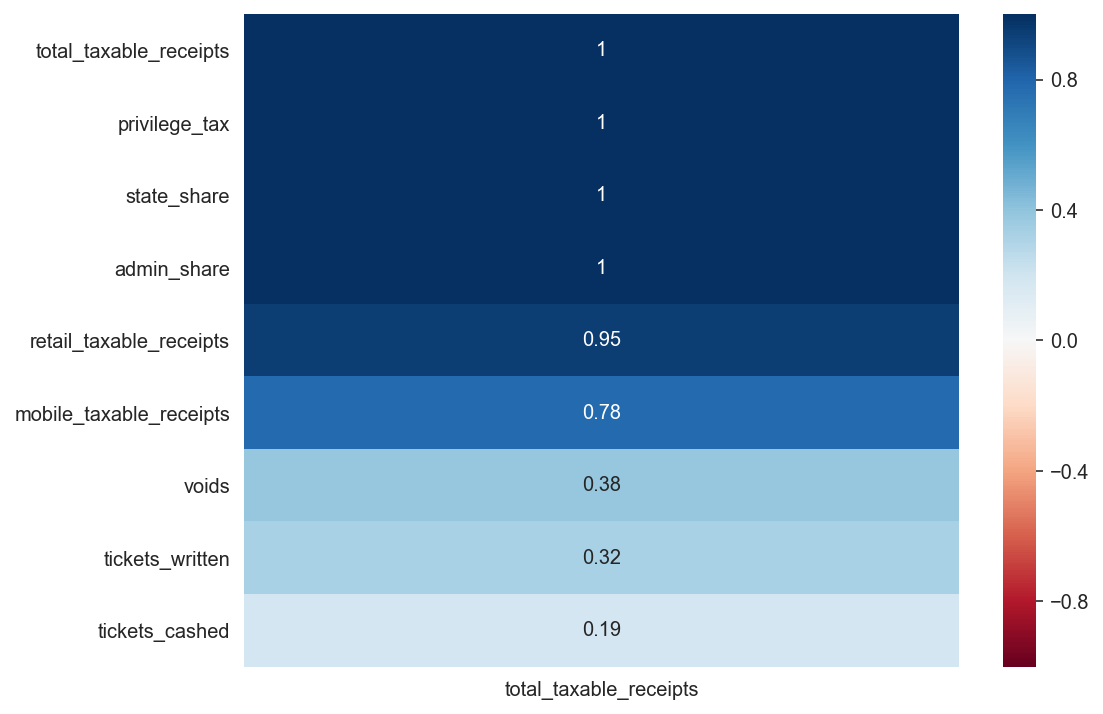

In [20]:
# Heatmap of the corrleations of features and revenue
plt.figure(figsize = (8,6))
sns.heatmap(df.corr()[["total_taxable_receipts"]].sort_values(by = 'total_taxable_receipts', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);

In [21]:
# Add Interpretation

# mention the features with a 1 correlation will not be included in modeling


#### Time Series Data Analysis

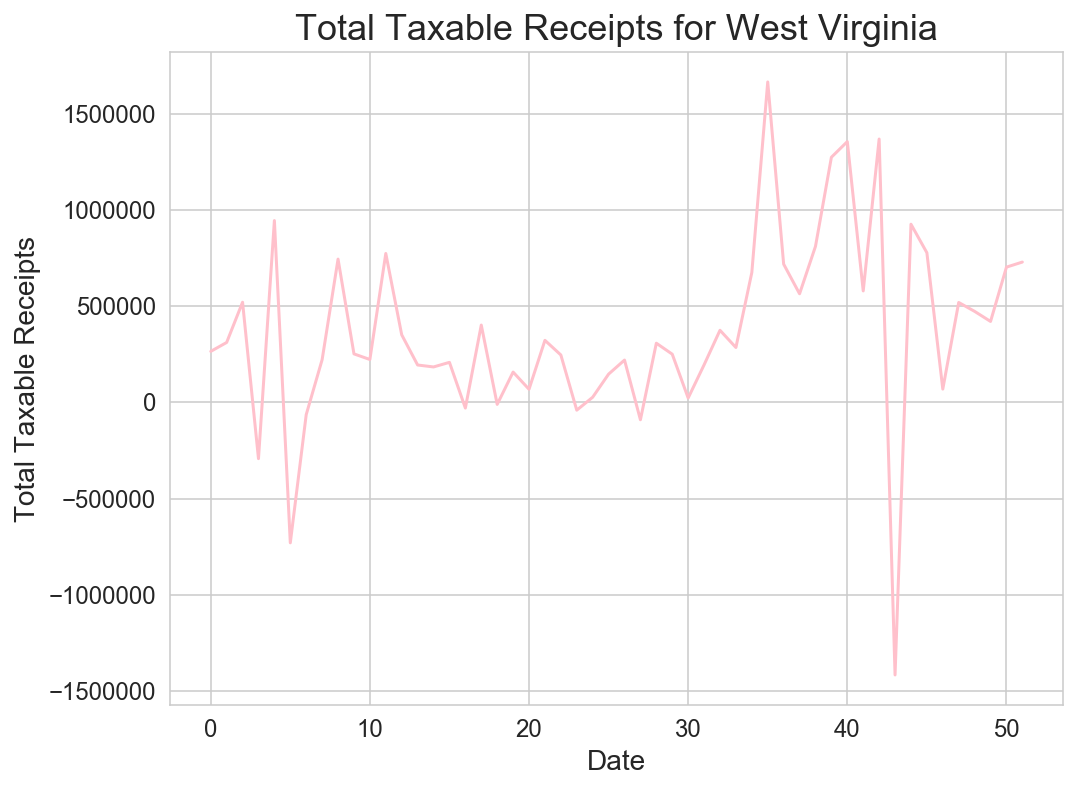

In [27]:
# Line plot for "Total Taxable Receipts" over time

plt.figure(figsize=(8,6))
plt.plot(total_taxable_receipts, color ='pink')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# x-axis is time
plt.xlabel('Date', fontsize=14)

# y-axis is total taxable receipts
plt.ylabel('Total Taxable Receipts', fontsize=14)

plt.title('Total Taxable Receipts for West Virginia', fontsize=18);

In [28]:
# Calculating rolling means for Total Taxable Receipts

rolling_mean_1  = total_taxable_receipts.rolling(window = 1).mean()
rolling_mean_4 = total_taxable_receipts.rolling(window = 4).mean()
rolling_mean_13 = total_taxable_receipts.rolling(window = 13).mean()

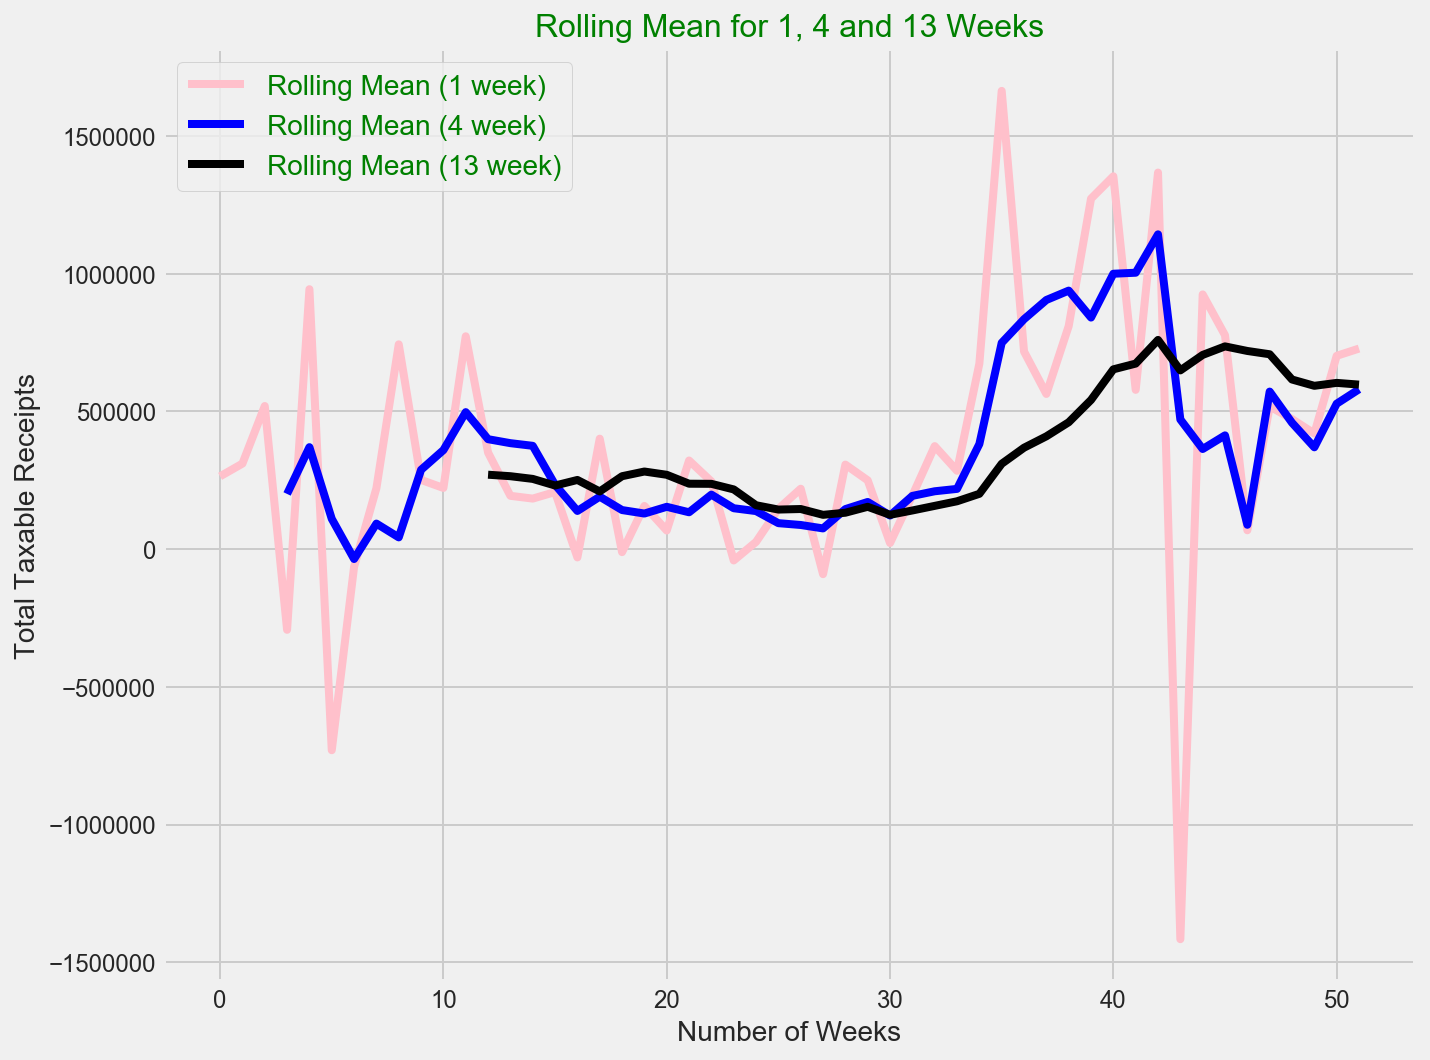

In [95]:
# Plot

plt.figure(figsize=(10,8))

plt.plot(rolling_mean_1, color='pink', label='Rolling Mean (1 week)')
plt.plot(rolling_mean_4, color='blue', label='Rolling Mean (4 week)')
plt.plot(rolling_mean_13, color='black', label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.xlabel('Number of Weeks', fontsize=14)
plt.ylabel('Total Taxable Receipts', fontsize=14)
plt.title('Rolling Mean for 1, 4 and 13 Weeks', fontsize=16);

1 week rolling mean: We see several significant spikes up and down over time. There is quite a large spike up in early September, and a very noticable spike down in late October, which has a large spike back following it, in early November. 

4 week rolling mean: We can see that there are changes over an approximate month of time. Those changes aren't steep spikes like the 1 week rolling mean line shows. but many less than the 1 week rolling mean line shows. The most noticable change is seen as an increase from September until November. This is when the NFL season gets underway.  

13 week rolling mean: We use a 13-week rolling mean to represent an approximate season of the year. The line does not include signficant spikes, but we do see a considerable rise in total taxable receipts in the fall, during the NFL season, when MLB playoffs are underway, and when the NBA season is beginning.  

In [35]:
# Relationship between Total Taxable Receipts and 1-lag Total Taxable Receipts
df["total_taxable_receipts"].autocorr(lag=1)

0.013471643479216042

In [36]:
# Relationship between Total Taxable Receipts and 4-lag Total Taxable Receipts
df["total_taxable_receipts"].autocorr(lag=2)

0.22298534166950224

In [37]:
# Relationship between Total Taxable Receipts and 13-lag Total Taxable Receipts
df["total_taxable_receipts"].autocorr(lag=13)

0.11420792604444066

In [38]:
df["total_taxable_receipts"].autocorr(lag=50)

1.0

In [39]:
# Add interpretation

#### Autocorrelation and Partial Autocorrelation Functions

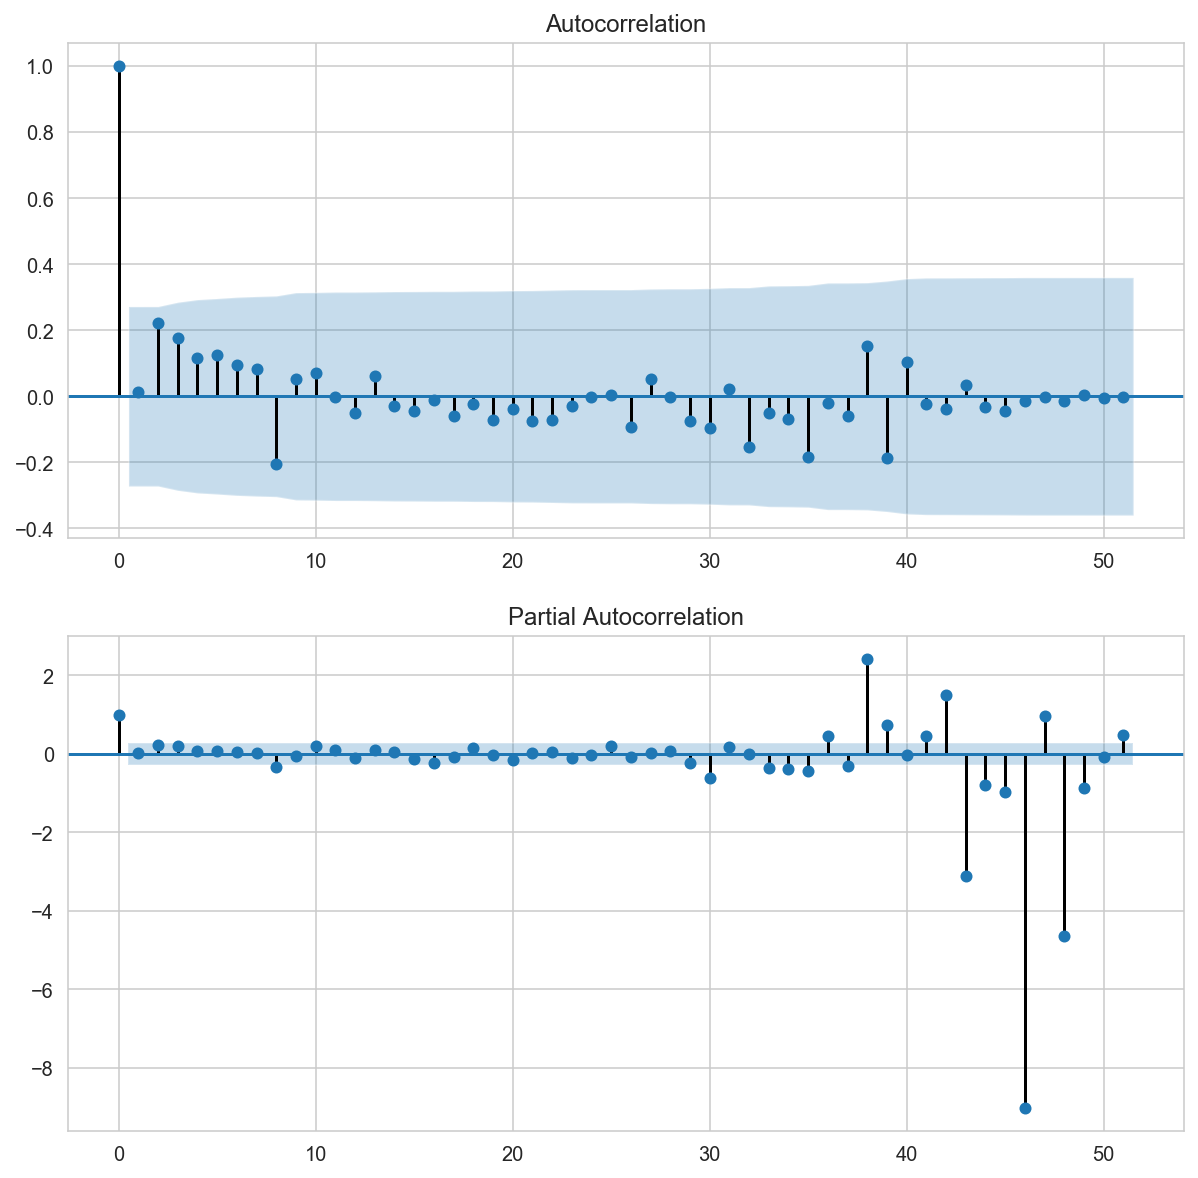

In [42]:
# Using Autocorrelation and Partial Autocorrelation plots to help understand seasonality

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(df[['total_taxable_receipts']], lags=51, ax=ax1)

ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(df[['total_taxable_receipts']], lags=51, ax=ax2)
plt.show();

In [41]:
# Add interpretation

### Preprocessing

#### Data Manipulation

In [43]:
df.set_index('week_ending', inplace=True)

In [25]:
total_taxable_receipts = pd.DataFrame(df['total_taxable_receipts'].groupby(df.index).sum())

In [44]:
df[['total_taxable_receipts']].head()

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066


#### Train-Test-Split

In [45]:
# Using a 75-25 split, our training set will be 39 rows and our test will be 13 rows

train = df.iloc[:40,]
test = df.iloc[40:,]

In [46]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='pink')
    plt.plot(test, c='blue');

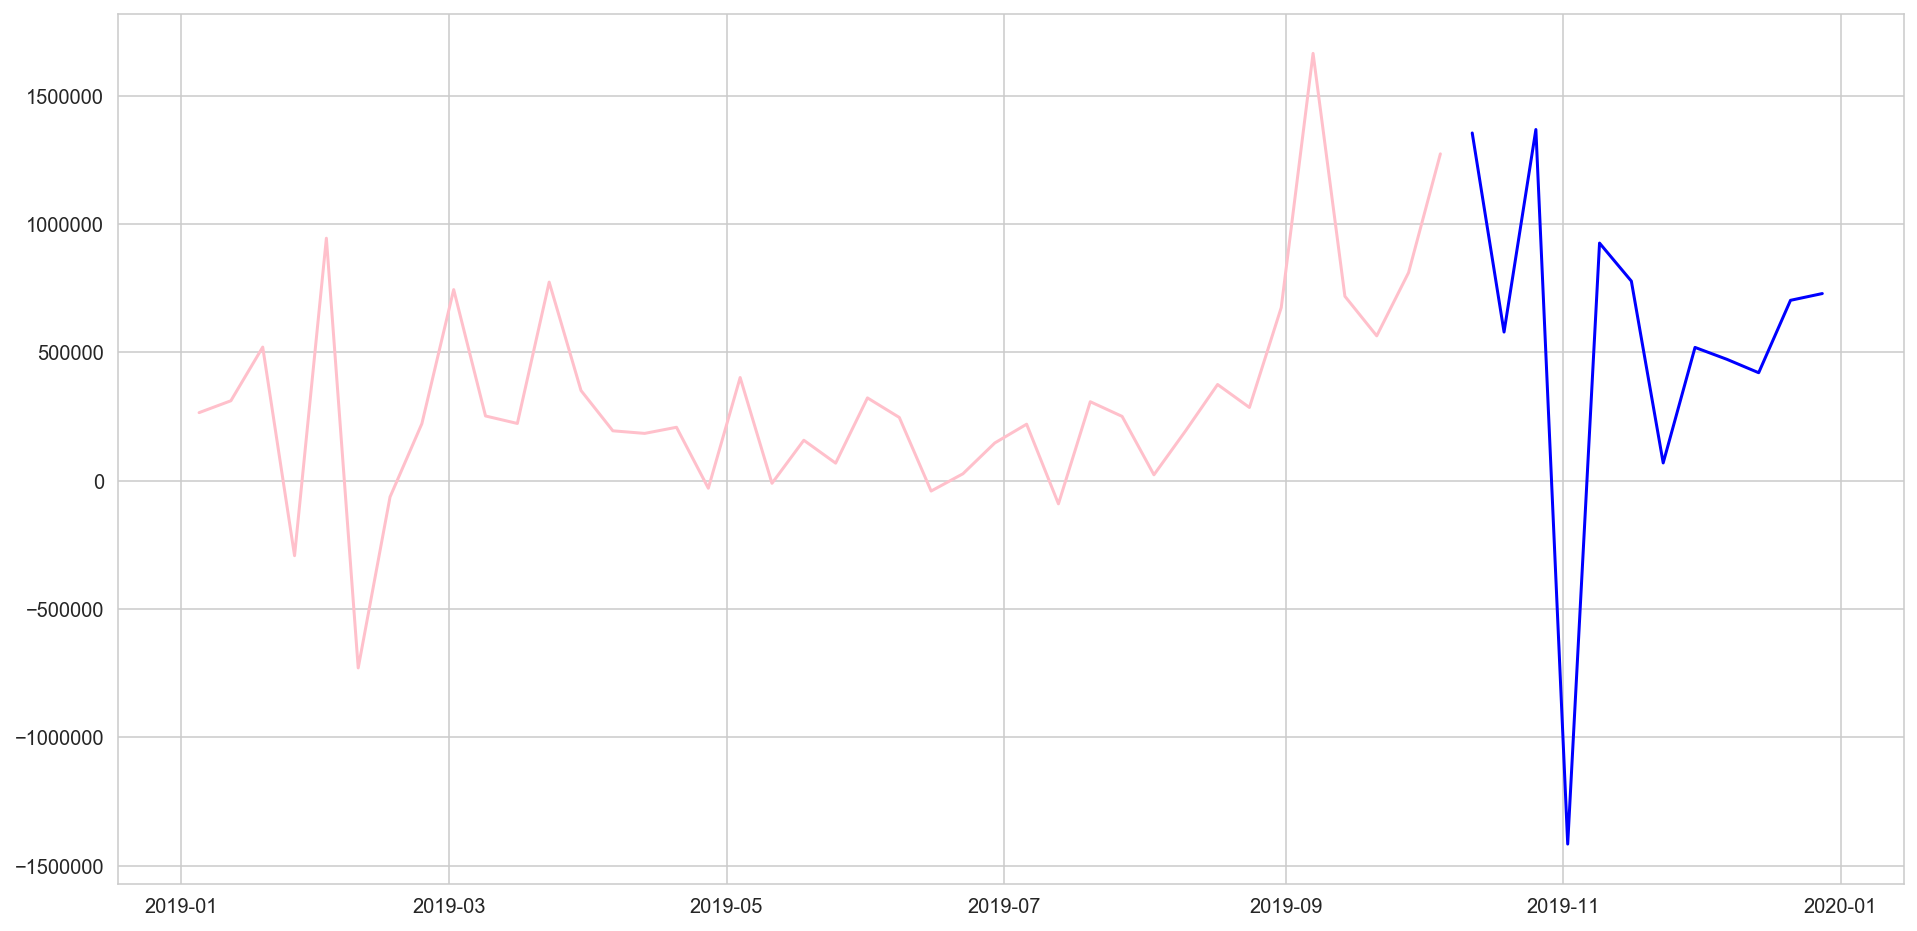

In [47]:
train_test_plot(train[['total_taxable_receipts']], test[['total_taxable_receipts']])

In [48]:
train.head()

#remove

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.000,210356,264445,26445,3967,22478
2019-01-12,4860953,138666,4411529,21356.000,289402,310758,31076,4661,26414
2019-01-19,4167883,75981,3572071,122956.000,396875,519831,51983,7797,44186
2019-01-26,3983320,73280,4202907,6185.000,-299052,-292867,-29287,-4393,-24894
2019-02-02,4622730,93425,3585239,81104.000,862961,944066,94407,14161,80246


In [49]:
test.head()

#remove

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-10-12,4478463,106603,6294572,406581.000,947614,1354195,135419,20313,115107
2019-10-19,3680379,94887,6082278,364190.000,214308,578497,57850,8677,49172
2019-10-26,4341311,82103,6399568,601782.000,765826,1367608,136761,20514,116247
2019-11-02,4165581,63569,9404206,-571570.000,-844841,-1416411,-141641,-21246,-120395
2019-11-09,4088691,88871,7335286,576236.000,348871,925107,92511,13877,78634


## Modeling

#### Baseline Modeling

In [99]:
# Comment out

train_mean = train['total_taxable_receipts'].mean()

In [100]:
# Comment out

baseline_preds = [train_mean for i in test['total_taxable_receipts']]

In [101]:
# Comment out

base_rmse = mean_squared_error(test['total_taxable_receipts'].values, baseline_preds)**0.5

In [102]:
print(f'Our Baseline Model has a Root Mean Squared Error of: {base_rmse}')

Our Baseline Model has a Root Mean Squared Error of: 724164.1823981728


#### Autoregressive Modeling

In [57]:
# Talk to Boom about this: Source

# Split training data into train values and dates

train_vals = train['total_taxable_receipts'].values
train_dates = train.index

In [58]:
# Talk to Boom about this: Source

AR1 = ARIMA(endog = train_vals,
              dates = train.index,
              order = (1,0,0)).fit()

In [59]:
# Split test data into values and dates
test_vals = test['total_taxable_receipts'].values
test_dates  = test.index

In [60]:
# Create start and end dates for predictions
start = test.index[0]
end = test.index[-1]

In [61]:
AR1_pred = AR1.predict(start = start,
                       end = end)

In [62]:
# Put predictions into a dataframe with a date range

date_list =  pd.date_range(start, periods=12, freq ='W')
predictions = pd.DataFrame(AR1_pred, index=date_list, columns = ['total_taxable_receipts'])

In [64]:
# Calculate and print RMSE
ar_rmse = mean_squared_error(test_vals, predictions) **.5
print(f'Our AR Model has a Root Mean Squared Error of: {ar_rmse}')

Our Baseline Model has a Root Mean Squared Error of: 699780.8352595273


In [65]:

# Look at min and max total taxable receipts, as well as how our MSE compares to them

print(f'Minimum TTR: {total_taxable_receipts["total_taxable_receipts"].min()}')
print(f'Maximum TTR: {total_taxable_receipts["total_taxable_receipts"].max()}')

Minimum TTR: -1416411
Maximum TTR: 1664244


In [67]:
#Look at how our RMSE compares to the minimum and maximum total taxable receipts

print(f'MSE relative to minimum values in series: {ar_rmse / total_taxable_receipts["total_taxable_receipts"].min()}')
print(f'MSE relative to maximum values in series: {ar_rmse / total_taxable_receipts["total_taxable_receipts"].max()}')

MSE relative to minimum values in series: -0.4940521044100387
MSE relative to maximum values in series: 0.42047971046284516


#### ARIMAX Modeling

In [68]:
# We will loop through ranges to find the optimal number of autoregressive terms (p),
# the number of nonseasonal differences (d) and the number of the moving-average terms (q)
# looping idea from Jason Brownlee


old_score = 1000000000000000000000

for p in range(3):
    for d in range(2):
        for q in range(3):
                # instantiate SARIMAX model
                model = SARIMAX(endog = train['total_taxable_receipts'],
                                exog = train[['tickets_written', 'voids']],
                                order = (p,d,q),
                                seasonal_order = (0,0,0,0)).fit()
                # predict
                y_hat = model.predict(start = test.index[0], 
                          end = test.index[-1],
                          exog = test[['tickets_written', 'voids']])
                
                # score using root mean squared error
                saved_score = mean_squared_error(test['total_taxable_receipts'].values, y_hat)**.5
                
                # print scores & parameters
                print(f'P,D,Q values: ({p,d,q}), Root Mean Squared Error: {saved_score}')
                
                # finding and using our best score
                if saved_score < old_score:
                    old_score = saved_score
                    best_params = (p,d,q)
                    
# print our best score and associated parameters
print('-----------------------------------------------------------------------')
print(f'Best RMSE achieved: {old_score} with these p,d,q values: {best_params}')

P,D,Q values: ((0, 0, 0)), Root Mean Squared Error: 673483.0205334281
P,D,Q values: ((0, 0, 1)), Root Mean Squared Error: 667225.076936715
P,D,Q values: ((0, 0, 2)), Root Mean Squared Error: 663370.5729713754
P,D,Q values: ((0, 1, 0)), Root Mean Squared Error: 1066851.7770107265
P,D,Q values: ((0, 1, 1)), Root Mean Squared Error: 749649.0047628373
P,D,Q values: ((0, 1, 2)), Root Mean Squared Error: 767938.7114808777
P,D,Q values: ((1, 0, 0)), Root Mean Squared Error: 665858.6789678294
P,D,Q values: ((1, 0, 1)), Root Mean Squared Error: 739505.2550290797
P,D,Q values: ((1, 0, 2)), Root Mean Squared Error: 677071.4807066517
P,D,Q values: ((1, 1, 0)), Root Mean Squared Error: 931039.6593838688
P,D,Q values: ((1, 1, 1)), Root Mean Squared Error: 771060.0505427652
P,D,Q values: ((1, 1, 2)), Root Mean Squared Error: 767245.0437204007
P,D,Q values: ((2, 0, 0)), Root Mean Squared Error: 675548.3052874246
P,D,Q values: ((2, 0, 1)), Root Mean Squared Error: 768936.6732635977
P,D,Q values: ((2, 0

In [69]:
final_model = SARIMAX(endog = train['total_taxable_receipts'],
                 exog = train[['tickets_written', 'voids']],
                 order = (0,0,2),
                 seasonal_order = (0,0,0,0)).fit()

In [70]:
# Use this if we include exongenous features
y_hat = final_model.predict(start = test.index[0], 
                          end = test.index[-1],
                          exog = test[['tickets_written', 'voids']])

In [75]:
y_hat

2019-10-12   655655.383
2019-10-19   576385.478
2019-10-26   465475.306
2019-11-02   418510.921
2019-11-09   459735.790
2019-11-16   416379.892
2019-11-23   433355.872
2019-11-30   525360.163
2019-12-07   421958.188
2019-12-14   470823.825
2019-12-21   459984.966
2019-12-28   466674.296
Freq: W-SAT, dtype: float64

In [72]:
sarimax_rmse = mean_squared_error(test['total_taxable_receipts'].values, y_hat)**.5
sarimax_rmse

663370.5729713754

In [ ]:
# The cells below was one idea of a baseline.... likely remove

In [ ]:
train_mean = train['total_taxable_receipts'].mean()
baseline_preds = [train_mean for i in test['total_taxable_receipts']]
mean_squared_error(test['total_taxable_receipts'].values, baseline_preds)**0.5

In [ ]:
baseline_preds = [train_mean for i in test['total_taxable_receipts']]

In [ ]:
mean_squared_error(test['total_taxable_receipts'].values, baseline_preds)**0.5

#### Model Comparison

In [76]:
print(f'AR Model RMSE: {ar_rmse}')
print(f'SARIMAX Model RMSE: {sarimax_rmse}')

AR Model RMSE: 699780.8352595273
SARIMAX Model RMSE: 663370.5729713754


Our score improved as seen by the reduction in RMSE from our AR model to our SARIMAX model

In [ ]:
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


Model configurations and the RMSE are printed as the models are evaluated The top three model configurations and their error are reported at the end of the run.

We can see that the best result was an RMSE of about 1,551 sales with the following configuration:

Trend Order: (0, 0, 0)
Seasonal Order: (1, 1, 0, 12)
Trend Parameter: ‘t’ (linear trend)

In [77]:
from pylab import rcParams
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

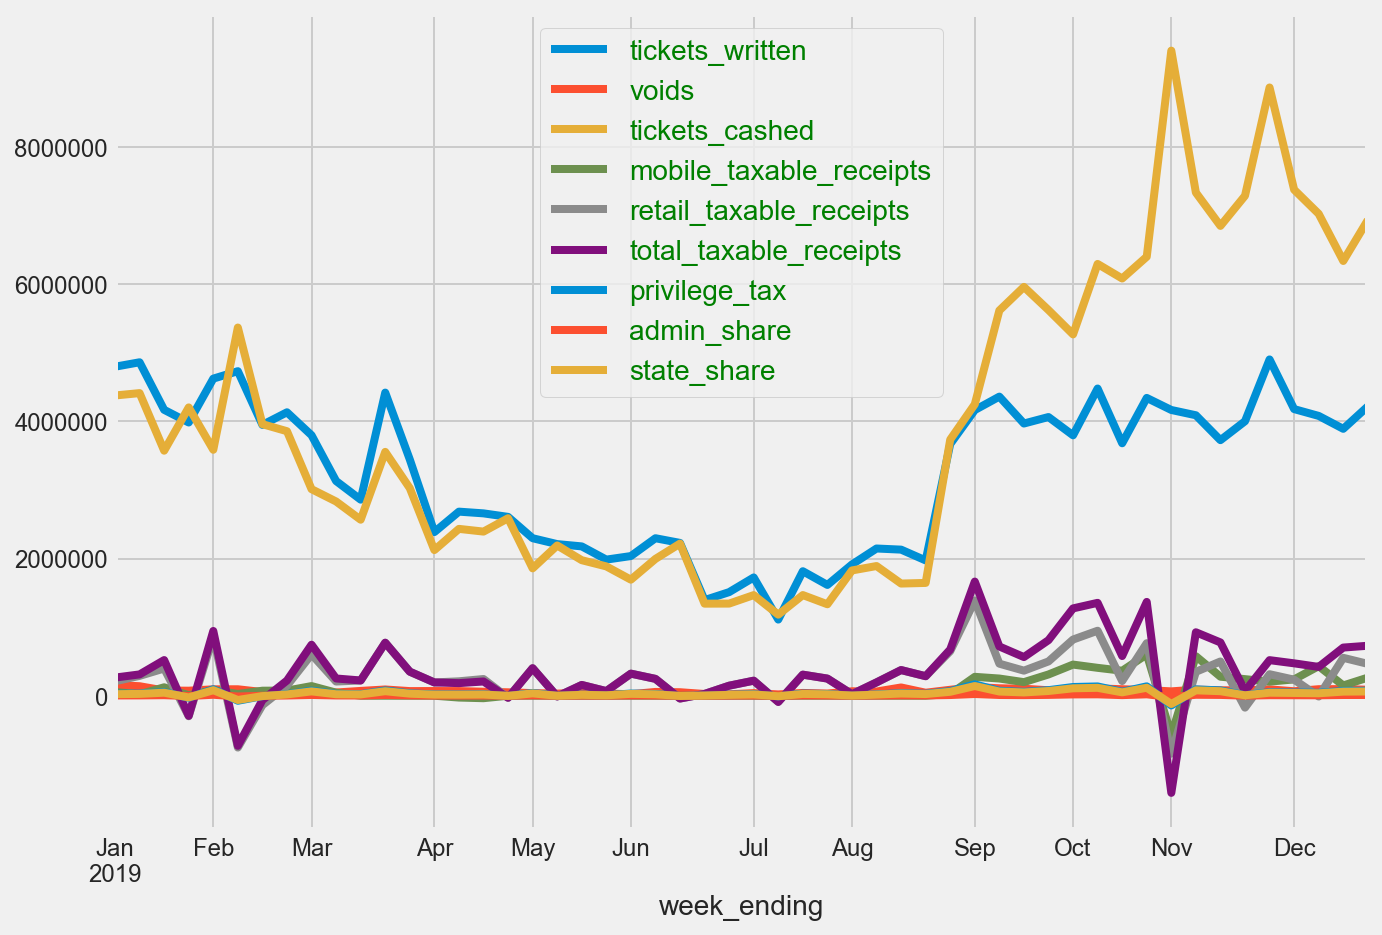

In [79]:
df.plot(figsize=(10,7))
plt.show()

Using the “sm.tsa.seasonal_decompose” command from the pylab library we can decompose the time-series into three distinct components: trend, seasonality, and noise.

In [91]:
df.head()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.000,210356,264445,26445,3967,22478
2019-01-12,4860953,138666,4411529,21356.000,289402,310758,31076,4661,26414
2019-01-19,4167883,75981,3572071,122956.000,396875,519831,51983,7797,44186
2019-01-26,3983320,73280,4202907,6185.000,-299052,-292867,-29287,-4393,-24894
2019-02-02,4622730,93425,3585239,81104.000,862961,944066,94407,14161,80246


In [94]:
df.drop(columns = 'admin_share', 'state_share', 'priveledge_tax')()

SyntaxError: positional argument follows keyword argument (<ipython-input-94-a9e9a52f0c94>, line 1)

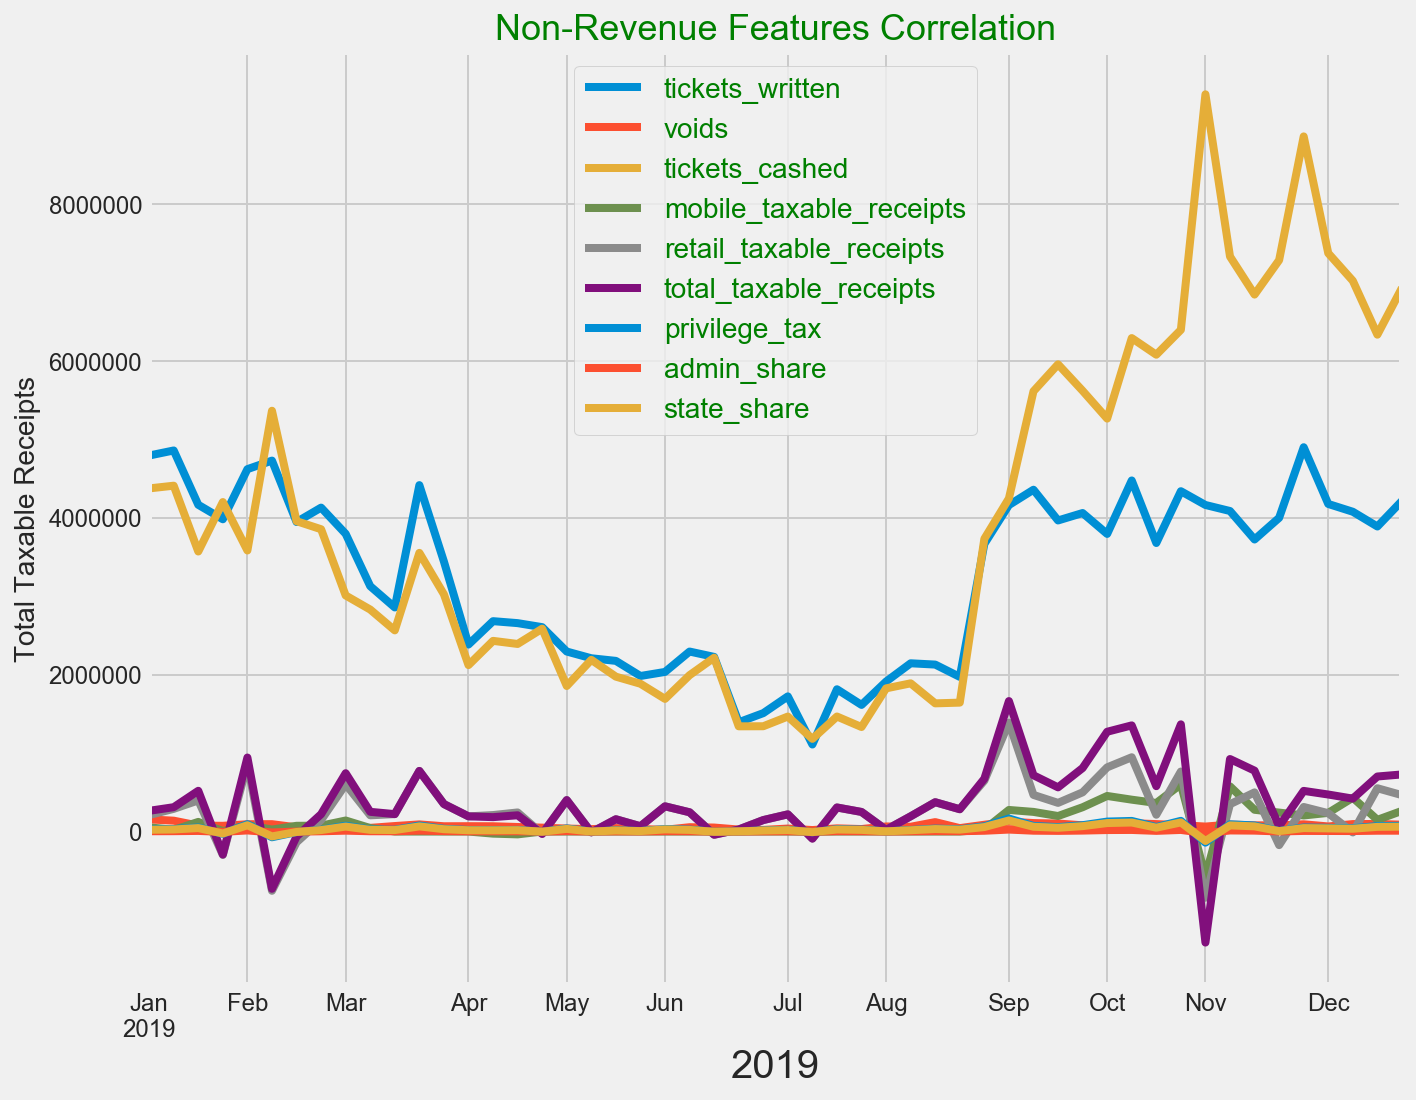

In [89]:
# Plotting all of the features in the data over the 52 weeks the data includes

df.plot(figsize = (10, 8))
plt.xlabel('2019', fontsize = 20)
plt.ylabel('Total Taxable Receipts', fontsize = 14)
plt.title("Non-Revenue Features Correlation", fontsize = 18)
plt.show();

#df.drop(columns = 'admin_share','state_share','priveledge_tax').plot(figsize = (10, 8))


### Conclusions and Recommendations